# Rails Issues Analysis

### 1. Importing Libraries

In [96]:
from json import loads
import requests
import pandas as pd
import matplotlib.pyplot as plt

### 2. Data Scraping

In [3]:
## Load the environment variables from the env.json file
file_path = "env.json"
with open(file_path, "r") as file:
    data = file.read()
    if data:
        data = loads(data)


In [9]:
## Get all issues from a GitHub repository
GITHUB_USER = data['username'] # github username
GITHUB_PASSWORD = data['password'] # github password
AUTH = (GITHUB_USER, GITHUB_PASSWORD) # basic auth

def get_all_issues(repo_owner, repo_name):
    url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/issues"
    issues = []
    page = 1

    while True:
        response = requests.get(url, params={"page": page}, auth=AUTH)
        if response.status_code == 200:
            page_issues = response.json()
            if len(page_issues) == 0:
                break
            issues.extend(page_issues)
            page += 1
        else:
            print(f'Error message: {response.json()["message"]}')
            print(f"Error: {response.status_code}")
            break

    return issues

# Example usage
repo_owner = "rails"
repo_name = "rails"
issues = get_all_issues(repo_owner, repo_name)

### 3. Data Cleaning and Preprocessing

In [10]:
### fitlering out the last 500 issues
issues = issues[0:500] # the issues are sorted by the date they were created, so we can just take the first 500

In [12]:
## issues keys
print(issues[0].keys())

dict_keys(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'draft', 'pull_request', 'body', 'reactions', 'timeline_url', 'performed_via_github_app', 'state_reason'])


In [78]:
## filtering the data for each issue (selected keys)
selected_keys = ["url", "id", "number", "title", "user", "labels", "state", "comments", "created_at", "updated_at", "closed_at", "body", "reactions"]

## filtering the data (using list comprehension)
filtered_issues = [{key: issue[key] for key in selected_keys} for issue in issues]

In [79]:
## filtering subkeys for the user, labels and reactions
selected_subkeys_user = ['login', 'id', 'type']
selected_subkeys_labels = ['name']
selected_subkeys_reactions = ['total_count']

# Create new keys for selected_subkeys_user
for index, issue in enumerate(filtered_issues):
    ## filtering the user subkeys
    for key in selected_subkeys_user:
        filtered_issues[index][key] = issue['user'][key]
   
    ## filtering the labels subkeys
    for key in selected_subkeys_labels:
        if len(issue['labels']) == 0:
            filtered_issues[index][key] = None
        else:
            names = []
            for label in issue['labels']:
                names.append(label[key])
            filtered_issues[index][key] = names
    
    ## filtering the reactions subkeys
    for key in selected_subkeys_reactions:
        filtered_issues[index][key] = issue['reactions'][key]
    


## removing the user, labels and reactions keys
for issue in filtered_issues:
    del issue['user']
    del issue['labels']
    del issue['reactions']




In [80]:
filtered_issues[2]

{'url': 'https://api.github.com/repos/rails/rails/issues/50953',
 'id': 1773614,
 'number': 50953,
 'title': 'Add webp as a default to active_storage.web_image_content_types',
 'state': 'open',
 'comments': 1,
 'created_at': '2024-02-02T12:51:26Z',
 'updated_at': '2024-02-02T17:19:56Z',
 'closed_at': None,
 'body': '### Motivation / Background\r\n\r\nCustomers are uploading webp images to our app, and expect them to be rendered just like other images, instead of being converted to the fallback PNG format.\r\n\r\n### Detail\r\n\r\nFollows https://github.com/rails/rails/pull/38918 and https://github.com/rails/rails/pull/38988. At the time, webp browser support was limited. Now 96% of browsers support webp: https://caniuse.com/?search=webp\r\n\r\nThis PR adds webp as a default image type.\r\n\r\n### Additional information\r\n\r\nI think this is a sensible default in 2024, but alternatively each Rails app may choose:\r\n\r\n```\r\nRails.application.configure do\r\n  config.active_storage.w

In [81]:
## create a DataFrame to store the filtered issues
df = pd.DataFrame(filtered_issues, columns=filtered_issues[0].keys())


In [82]:
df.head() # print the first 5 rows of the DataFrame

,url,id,number,title,state,comments,created_at,updated_at,closed_at,body,login,type,name,total_count
0,https://api.github.com/repos/rails/rails/issue...,9632282,50958,Add missing alias to errors array,open,0,2024-02-03T01:01:09Z,2024-02-03T01:01:13Z,None,it used to be that the << operator was able to...,laomatt,User,[activemodel],0
1,https://api.github.com/repos/rails/rails/issue...,58818799,50954,esbuild precompilation error in rails 7.1.3,open,0,2024-02-02T14:43:34Z,2024-02-02T14:43:34Z,None,### Steps to reproduce\r\ncreate a new rails 7...,PhilippGsell,User,None,0
2,https://api.github.com/repos/rails/rails/issue...,1773614,50953,Add webp as a default to active_storage.web_im...,open,1,2024-02-02T12:51:26Z,2024-02-02T17:19:56Z,None,### Motivation / Background\r\n\r\nCustomers a...,lewispb,User,"[railties, docs, activestorage]",0
3,https://api.github.com/repos/rails/rails/issue...,4509402,50951,set default_enforce_utf8 to false,open,1,2024-02-02T11:11:21Z,2024-02-03T08:41:29Z,None,`enforce_utf8` is false by deault in `form_for...,ironsand,User,[actionview],0
4,https://api.github.com/repos/rails/rails/issue...,54796266,50950,Add class name to enum validation exception me...,open,0,2024-02-02T11:07:18Z,2024-02-02T11:08:08Z,None,### Motivation / Background\r\n\r\nIn general ...,amkisko,User,[activerecord],0


In [83]:
## rename the column name (name to label)
df.rename(columns={'name': 'label'}, inplace=True)

In [84]:
## convert the label to multiple columns

# Split the labels into individual values
df['label'] = df['label'].str.join(',')

# Create new columns for each label value
df = df.join(df['label'].str.split(',', expand=True).add_prefix('label_'))

# Drop the original label column
df.drop('label', axis=1, inplace=True)


In [85]:
df.head() # print the first 5 rows of the DataFrame

,url,id,number,title,state,comments,created_at,updated_at,closed_at,body,...,total_count,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8
0,https://api.github.com/repos/rails/rails/issue...,9632282,50958,Add missing alias to errors array,open,0,2024-02-03T01:01:09Z,2024-02-03T01:01:13Z,None,it used to be that the << operator was able to...,...,0,activemodel,None,None,None,None,None,None,None,None
1,https://api.github.com/repos/rails/rails/issue...,58818799,50954,esbuild precompilation error in rails 7.1.3,open,0,2024-02-02T14:43:34Z,2024-02-02T14:43:34Z,None,### Steps to reproduce\r\ncreate a new rails 7...,...,0,None,None,None,None,None,None,None,None,None
2,https://api.github.com/repos/rails/rails/issue...,1773614,50953,Add webp as a default to active_storage.web_im...,open,1,2024-02-02T12:51:26Z,2024-02-02T17:19:56Z,None,### Motivation / Background\r\n\r\nCustomers a...,...,0,railties,docs,activestorage,None,None,None,None,None,None
3,https://api.github.com/repos/rails/rails/issue...,4509402,50951,set default_enforce_utf8 to false,open,1,2024-02-02T11:11:21Z,2024-02-03T08:41:29Z,None,`enforce_utf8` is false by deault in `form_for...,...,0,actionview,None,None,None,None,None,None,None,None
4,https://api.github.com/repos/rails/rails/issue...,54796266,50950,Add class name to enum validation exception me...,open,0,2024-02-02T11:07:18Z,2024-02-02T11:08:08Z,None,### Motivation / Background\r\n\r\nIn general ...,...,0,activerecord,None,None,None,None,None,None,None,None


In [86]:
## data types
print(df.dtypes)

url            object
id              int64
number          int64
title          object
state          object
comments        int64
created_at     object
updated_at     object
closed_at      object
body           object
login          object
type           object
total_count     int64
label_0        object
label_1        object
label_2        object
label_3        object
label_4        object
label_5        object
label_6        object
label_7        object
label_8        object
dtype: object


In [87]:
## change the data type of the created_at, updated_at and closed_at columns to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df['closed_at'] = pd.to_datetime(df['closed_at'])


In [88]:
## data types
print(df.dtypes)

url                         object
id                           int64
number                       int64
title                       object
state                       object
comments                     int64
created_at     datetime64[ns, UTC]
updated_at     datetime64[ns, UTC]
closed_at           datetime64[ns]
body                        object
login                       object
type                        object
total_count                  int64
label_0                     object
label_1                     object
label_2                     object
label_3                     object
label_4                     object
label_5                     object
label_6                     object
label_7                     object
label_8                     object
dtype: object


In [89]:
### save the DataFrame to a csv file
file_path = "github-issues.csv"
df.to_csv(file_path, index=False)

### 4. Data Analysis, statistics and visualization

In [100]:
## load the DataFrame from the csv file
file_path = "github-issues.csv"
df = pd.read_csv(file_path)

#### 4.1. How do the number of issues evolve over time?

In [101]:

df['created_at'] = pd.to_datetime(df['created_at']) # convert 'created_at' column to datetime if it's not already

# Set 'created_at' column as the index
df.set_index('created_at', inplace=True)



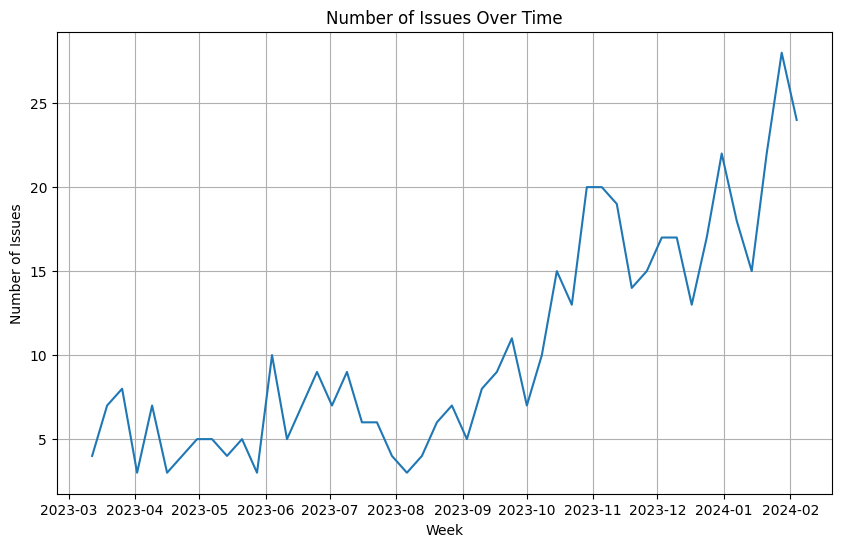

In [103]:
# Plot the number of issues created during each week

# Resample the dataframe to weekly bins and count the number of issues created in each week
weekly_issues = df.resample('W').size()

plt.figure(figsize=(10, 6))  # Adjust the figure size
plt.plot(weekly_issues)
plt.xlabel('Week')
plt.ylabel('Number of Issues')
plt.title('Number of Issues Over Time')
plt.grid(True)  # Add grid lines
plt.show()


### 5. Predictive Analysis and Model Building

### 6. Conclusion